In [1]:
import requests
import lxml.html

In [2]:
from xml.etree.ElementTree import *

In [3]:
r = requests.get("http://www.asahi-net.or.jp/~tk7m-ari/sazae_ichiran.html", verify=False)
requestEncode = r.encoding
request = r.text.encode(requestEncode)

In [17]:
from pyquery import PyQuery
pq = PyQuery(url='http://www.asahi-net.or.jp/~tk7m-ari/sazae_ichiran.html')

In [18]:
re = str(request)
lis=list()
lis.append(re)
l=lis[0] 
ls = l.split("<BR>")

In [21]:
i = 0
lis = list()
for i in range(len(ls)):
    if 'x83O' in ls[i]:
        m = 'G'
        lis.append(m)
    if 'x83p' in ls[i]:
        m = 'P'
        lis.append(m)
    if 'x83L' in ls[i]:
        m = 'X'
        lis.append(m)
    else:
        pass

In [23]:
import numpy as np
lb2 = np.zeros((3,3))
J = ['X','P','G']
ls3 = lis[:500]
i = 0
q = 0
a = 0
for i in range(3):
    for q in range(3):
        for a in range(len(ls3)-1):
            b = ls3[499-a]
            if J[i] in b:
                c = ls3[498-a]
                if J[q] in c:
                    lb2[i][q] = lb2[i][q]+1
            else:
                pass
lb2

array([[ 24.,  75.,  73.],
       [ 79.,  35.,  55.],
       [ 69.,  58.,  31.]])

ここから、機械学習を利用して、次に出る手を予測するモデルを作り、精度をvalidationによって確かめたい。

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
import time
import datetime as dt

"""
じゃんけん用学習データを生成するクラス。
本来であればプログラムでデータを自動生成するのではなく、
人が実際にじゃんけんをして得られる”手作り”データを用いる方が
「機械に人間の行動を学習させる」例としては良いのだが
今回は簡単なデモということでデータを自動生成させている。
"""
class RockScissorsPaper:
    def __init__(self, number_of_data=1000):
        self.number_of_data = number_of_data

    # 相手が出すじゃんけんの手の確率
    # 戻値：[グーを出す確率, チョキを出す確率, パーを出す確率]
    def opponent_hand(self):
        rand_rock = np.random.rand()
        rand_scissors = np.random.rand()
        rand_paper = np.random.rand()
        total = rand_rock + rand_scissors + rand_paper
        return [rand_rock/total, rand_scissors/total, rand_paper/total]

    # グーが来る確率が一番高かったらパー、
    # チョキが来る確率が一番高かったらグー、
    # パーが来る確率が一番高かったらチョキ
    # を返す。
    # 引数：[グーが来る確率, チョキが来る確率, パーが来る確率]
    # 戻値：[グーを返すか否か(0or1), チョキを返すか否か(0or1), パーを返すか否か(0or1)]
    #
    # 例:
    # 引数が[0.6, 0.3, 0.1]の時、グーが来る確率が60%で最も高いため、
    # グーに勝てるパーを出すため戻値は[0, 0, 1]となる。
    def winning_hand(self, rock, scissors, paper) -> [float, float, float]:
        mx = max([rock, scissors, paper])
        if rock == mx: return [0, 0, 1]
        if scissors == mx: return [1, 0, 0]
        if paper == mx: return [0, 1, 0]

    # この手が来た時にあの手を返すと勝てる、を集めた学習用データ
    def get_supervised_data(self, n_data=None):
        if n_data is None:
            n_data = self.number_of_data

        # トレーニングデータ生成
        supervised_data_input = []
        supervised_data_output = []
        for i in range(n_data):
            rock_prob, scissors_prob, paper_prob = self.opponent_hand()
            input_probs = [rock_prob, scissors_prob, paper_prob]
            supervised_data_input.append(input_probs)
            supervised_data_output.append(self.winning_hand(*input_probs))
        return {'input': supervised_data_input, 'output': supervised_data_output}


"""
ここからTensorFlowの機械学習用の処理
処理は下記の流れで実行
(1) 入力層の作成
(2) 隠し層、出力層の作成
(3) 誤差の定義
(4) 学習用TensorFlow Operationの作成
(5) 学習実行
(6) 学習結果検証
"""
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('summary-dir', '/tmp/tensorflow/summary',
                           "TensorBoard用のログを出力するディレクトリのパス")
tf.app.flags.DEFINE_integer('max-epoch', 100, "最大学習エポック数")
tf.app.flags.DEFINE_integer('batch-size', 10, "1回のトレーニングステップに用いるデータのバッチサイズ")
tf.app.flags.DEFINE_float('learning-rate', 0.07, "学習率")
tf.app.flags.DEFINE_integer('test-data', 10, "テスト用データの数")
tf.app.flags.DEFINE_integer('training-data', 1000, "学習用データの数")
tf.app.flags.DEFINE_boolean('skip-training', False, "学習をスキップしてテストだけする場合は指定")


def train_and_test(training_data, test_data):
    if len(training_data['input']) != len(training_data['output']):
        print("トレーニングデータの入力と出力のデータの数が一致しません")
        return
    if len(test_data['input']) != len(test_data['output']):
        print("テストデータの入力と出力のデータの数が一致しません")
        return

    # ニューラルネットワークの入力部分の作成
    with tf.name_scope('Inputs'):
        input = tf.placeholder(tf.float32, shape=[None, 3], name='Input')
    with tf.name_scope('Outputs'):
        true_output = tf.placeholder(tf.float32, shape=[None, 3], name='Output')

    # ニューラルネットワークのレイヤーを作成する関数
    def hidden_layer(x, layer_size, is_output=False):
        name = 'Hidden-Layer' if not is_output else 'Output-Layer'
        with tf.name_scope(name):
            # 重み
            w = tf.Variable(tf.random_normal([x._shape[1].value, layer_size]), name='Weight')
            # バイアス
            b = tf.Variable(tf.zeros([layer_size]), name='Bias')
            # 入力総和(バッチ単位)
            z = tf.matmul(x, w) + b
            a = tf.tanh(z) if not is_output else z
        return a

    # レイヤーを作成
    # 3-10-10-3のDNN
    layer1 = hidden_layer(input, 10)
    layer2 = hidden_layer(layer1, 10)
    output = hidden_layer(layer2, 3, is_output=True)

    # 誤差の定義
    with tf.name_scope("Loss"):
        # クロスエントロピー
        with tf.name_scope("Cross-Entropy"):
            error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_output, logits=output))
        # 真の出力と計算した出力がどれだけ一致するか
        with tf.name_scope("Accuracy"):
            accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(true_output, 1), tf.argmax(output, 1)), tf.float32)) * 100.0
        with tf.name_scope("Prediction"):
            # 出力値を確率にノーマライズするOP(起こりうる事象の和を1にする)
            prediction = tf.nn.softmax(output)

    # 学習用OPの作成
    with tf.name_scope("Train"):
        train_op = tf.train.GradientDescentOptimizer(FLAGS.learning_rate).minimize(error)

    # セッション生成、変数初期化
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # TensorBoard用サマリ
    writer = tf.summary.FileWriter(FLAGS.summary_dir + '/' + dt.datetime.now().strftime('%Y%m%d-%H%M%S'), sess.graph)
    tf.summary.scalar('CrossEntropy', error)
    tf.summary.scalar('Accuracy', accuracy)
    summary = tf.summary.merge_all()

    # 学習を実行する関数
    def train():
        print('----------------------------------------------学習開始----------------------------------------------')
        batch_size = FLAGS.batch_size
        loop_per_epoch = int(len(training_data['input']) / batch_size)
        max_epoch = FLAGS.max_epoch
        print_interval = max_epoch / 10 if max_epoch >= 10 else 1
        step = 0
        start_time = time.time()
        for e in range(max_epoch):
            for i in range(loop_per_epoch):
                batch_input = training_data['input'][i*batch_size:(i+1)*batch_size]
                batch_output = training_data['output'][i*batch_size:(i+1)*batch_size]
                _, loss, acc, report = sess.run([train_op, error, accuracy, summary], feed_dict={input: batch_input, true_output: batch_output})
                step += batch_size

            writer.add_summary(report, step)
            writer.flush()

            if (e+1) % print_interval == 0:
                learning_speed = (e + 1.0) / (time.time() - start_time)
                print('エポック:{:3}    クロスエントロピー:{:.6f}    正答率:{:6.2f}%    学習速度:{:5.2f}エポック/秒'.format(e+1, loss, acc, learning_speed))

        print('----------------------------------------------学習終了----------------------------------------------')
        print('{}エポックの学習に要した時間: {:.2f}秒'.format(max_epoch, time.time() - start_time))

    # 学習成果をテストする関数
    def test():
        print('----------------------------------------------検証開始----------------------------------------------')
        # ヘッダー
        print('{:5}  {:20}      {:20}      {:20}      {:2}'.format('', '相手の手', '勝てる手', 'AIの判断', '結果'))
        print('{}  {:3}   {:3}   {:3}      {:3}   {:3}   {:3}      {:3}   {:3}   {:3}'.format('No.  ', 'グー　', 'チョキ', 'パー　', 'グー　', 'チョキ', 'パー　', 'グー　', 'チョキ', 'パー　'))

        # 最も確率の高い手を強調表示するための関数
        def highlight(rock, scissors, paper):
            mx = max(rock, scissors, paper)
            rock_prob_em = '[{:6.4f}]'.format(rock) if rock == mx else '{:^8.4f}'.format(rock)
            scissors_prob_em = '[{:6.4f}]'.format(scissors) if scissors == mx else '{:^8.4f}'.format(scissors)
            paper_prob_em = '[{:6.4f}]'.format(paper) if paper == mx else '{:^8.4f}'.format(paper)
            return [rock_prob_em, scissors_prob_em, paper_prob_em]

        # N回じゃんけんさせてみてAIが勝てる手を正しく判断できるか検証
        win_count = 0
        for k in range(len(test_data['input'])):
            input_probs = [test_data['input'][k]]
            output_probs = [test_data['output'][k]]

            # 検証用オペレーション実行
            acc, predict = sess.run([accuracy, prediction], feed_dict={input: input_probs, true_output: output_probs})

            best_bet_label = np.argmax(output_probs, 1)
            best_bet_logit = np.argmax(predict, 1)
            result = '外れ'
            if best_bet_label == best_bet_logit:
                win_count += 1
                result = '一致'

            print('{:<5} {:8} {:8} {:8}'.format(*(tuple([k+1]+highlight(*input_probs[0])))), end='')
            print('    ', end='')
            print('{:8} {:8} {:8}'.format(*tuple(highlight(*output_probs[0]))), end='')
            print('    ', end='')
            print('{:8} {:8} {:8}'.format(*tuple(highlight(*predict[0]))), end='')
            print('    ', end='')
            print('{:2}'.format(result))

        print('----------------------------------------------検証終了----------------------------------------------')
        print('AIの勝率: {}勝/{}敗 勝率{:4.3f}%'.format(win_count, FLAGS.test_data-win_count, (win_count/len(test_data['input']) * 100.0)))

    print('学習無しの素の状態でAIがじゃんけんに勝てるか確認')
    test()

    if not FLAGS.skip_training:
        train()
        print('学習後、AIのじゃんけんの勝率はいかに…！')
        test()


def main(argv=None):
    # 学習用データ取得
    janken = RockScissorsPaper()
    training_data = janken.get_supervised_data(FLAGS.training_data)
    test_data = janken.get_supervised_data(FLAGS.test_data)

    train_and_test(training_data, test_data)

if __name__ == '__main__':
    tf.app.run()

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Instructions for updating:
Use `argmax` instead
学習無しの素の状態でAIがじゃんけんに勝てるか確認
----------------------------------------------検証開始----------------------------------------------
       相手の手                      勝てる手                      AIの判断                     結果
No.    グー　   チョキ   パー　      グー　   チョキ   パー　      グー　   チョキ   パー　
1     [0.5540]  0.0929   0.3531      0.0000   0.0000  [1.0000]     0.0109   0.0290  [0.9601]    一致
2      0.2103  [0.5210]  0.2686     [1.0000]  0.0000   0.0000      0.0058   0.0055  [0.9887]    外れ
3      0.4535   0.0539  [0.4926]     0.0000  [1.0000]  0.0000      0.0100   0.0179  [0.9721]    外れ
4     [0.4591]  0.1953   0.3456      0.0000   0.0000  [1.0000]     0.0095   0.0205  [0.9700]    一致
5      0.2120  [0.4760]  0.3120     [1.0000]  0.0000   0.0000      0.0060   0.0052  [0.9888]    外れ
6      0.4870  [0.5118]  0.0011     [1.0000]  0.0000   0.0000      0.0053   0.0196  [0.9751]    外れ
7      0.3122  [0.4669]  0.2210     [1.0000]  0.0000   0.0000      0.0057   0.0098

SystemExit: 

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
import sklearn.tree
import sklearn.datasets
import sklearn.cross_validation

#データの読み込み
X, y = sklearn.datasets.load_svmlight_file('sazae.tri.txt')

#深さを変えて実験
for d in range(1, 7):
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=d)
    result = sklearn.cross_validation.cross_val_score(clf, X.toarray(), y, cv=20)
    print(u'最大深さ: {}, 正解率の平均: {:.1%}'.format(d, result.mean()))

最大深さ: 1, 正解率の平均: 42.6%
最大深さ: 2, 正解率の平均: 48.4%
最大深さ: 3, 正解率の平均: 49.9%
最大深さ: 4, 正解率の平均: 51.2%
最大深さ: 5, 正解率の平均: 51.5%
最大深さ: 6, 正解率の平均: 51.3%


In [35]:
import sklearn.tree
import sklearn.datasets
import io
from io import StringIO
import contextlib

X, y = sklearn.datasets.load_svmlight_file('sazae.tri.txt')

clf = sklearn.tree.DecisionTreeClassifier(max_depth=2)

clf.fit(X.toarray(), y)

with contextlib.closing(StringIO.()) as temp:
    sklearn.tree.export_graphviz(clf, out_file=temp, feature_names='グー(3手前) チョキ(3手前) パー(3手前) グー(2手前) チョキ(2手前) パー(2手前) グー(1手前) チョキ(1手前) パー(1手前)'.split())
    output = temp.getvalue().splitlines()

#日本語を表示するときはフォントを指定しないといけない
output.insert(1, 'node[fontname="meiryo"];')
with open('tree.dot', 'w') as f:
    f.write('\n'.join(output)) 

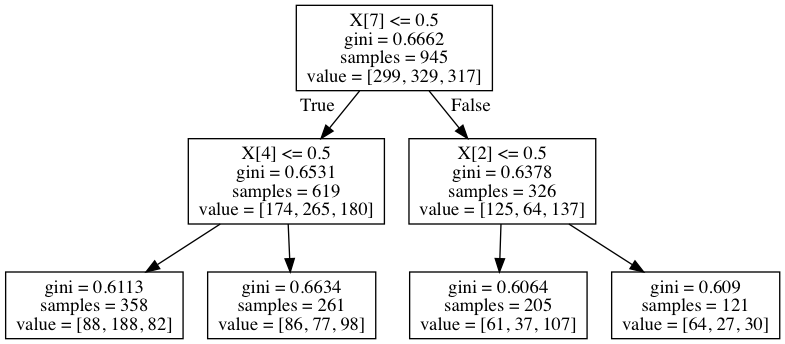

In [40]:
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
 
graph.write_pdf("graph.pdf")
from IPython.display import Image
Image(graph.create_png())